In [33]:
import brian2 as b2
import numpy as np
import matplotlib.pyplot as plt
from brian2 import *

In [37]:
def my_OU(pars, mu, sig, myseed=False):
  """
  Function that produces Ornstein-Uhlenbeck input

  Args:
    pars       : parameter dictionary
    sig        : noise amplitute
    myseed     : random seed. int or boolean

  Returns:
    I_ou       : Ornstein-Uhlenbeck input current
  """

  # Retrieve simulation parameters
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size
  tau_ou = pars['tau_ou']  # [ms]

  # set random seed
  if myseed:
    np.random.seed(seed=myseed)
  else:
    np.random.seed()

  # Initialize
  noise = np.random.randn(Lt)
  I_ou = np.zeros(Lt)
  I_ou[0] = noise[0] * sig

  # generate OU
  for it in range(Lt-1):
    I_ou[it+1] = I_ou[it] + (dt / tau_ou) * (mu - I_ou[it]) + np.sqrt(2 * dt / tau_ou) * sig * noise[it + 1]

  return I_ou

def run_LIF(pars,Iinj, stop=False):
    V_th, V_reset = pars['V_th'], pars['V_reset']
    tau_m, g_L = pars['tau_m'], pars['g_L']
    V_init, E_L = pars['V_init'], pars['E_L']
    dt, range_t = pars['dt'], pars['range_t']
    T = pars['T']
    seed = pars['seed']
    Lt = range_t.size
    tref = pars['tref']
    v = np.zeros(Lt)
    v[0] = V_init


    rec_spikes = []
    tr = 0.

    for it in range(Lt - 1):
        if tr > 0:
            v[it] = V_reset
            tr = tr - 1

        elif v[it] >= V_th:
            rec_spikes.append(it)
            v[it] = V_reset
            tr = tref / dt

        dv = (-(v[it] - E_L) + Iinj[it] / g_L) * (dt / tau_m)
        v[it + 1] = v[it] + dv
        rec_spikes_ = np.array(rec_spikes) * dt

    return v, rec_spikes_, Iinj

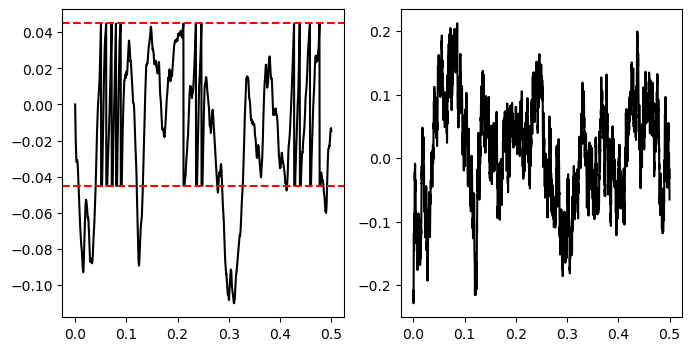

24.0


In [39]:

default_pars['T'] = 500
default_pars['dt'] = 0.1
# default_pars['V_th'] = 0.045
# default_pars['V_reset'] = -0.045

default_pars['range_t'] = np.arange(default_pars['T']/default_pars['dt'])

spikes_t_s_u = []
spikes_t_s_r = []
N_stim = 1
fig,ax = plt.subplots(1,2,figsize=[8,4])

SNR = 0.6
st = my_OU(default_pars, 0,0.1, myseed=0)
nt = my_OU(default_pars, 0,0.1, )
Iinj = SNR * st + np.sqrt(1 - SNR) * nt
# If current pulse, set beginning and end to 0
# Iinj = np.ones((int(default_pars['T']/default_pars['dt'])))*1000
# Iinj[:int(len(Iinj) / 2) - 1000] = 0
# Iinj[int(len(Iinj) / 2) + 1000:] = 0

# for i in range(N_stim):
default_pars['seed'] = 1
v, spikes, I = run_LIF(default_pars,Iinj)
spikes_t_s_u.append(spikes)


ax[0].plot(np.arange(0,0.5,0.0001),v,c='black')
ax[0].axhline(y=default_pars['V_th'],linestyle='--',c='red')
ax[0].axhline(y=default_pars['V_reset'],linestyle='--',c='red')

# ax[0].scatter(np.array(spikes / 0.1 - 0.01, dtype=np.int32), v[np.array(spikes / 0.1 - 0.01, dtype=np.int32)])
ax[1].plot(np.arange(0,0.5,0.0001),I,c='black')
plt.show()
print(len(spikes)/0.5)